## Rat Inspection Data Cleaning

This notebook cleans the data in the folder scr/data/split_up_rat_insepection_data and saves the results to folder scr/data/cleaned_rat_inspection_data. The main steps of our cleaning process are outlined as follows.

1. We first made column names lower case and replaced spaces with underscores.

2. We updated the entries for borough based on the borough_code column.

3. We dropped the redundant borough_code column. We also see that the location column is redundant so we drop that as well.

4. We observed that there were some outliers for inspection_date of certain entries. We also saw that most of the data is concentrated from 01-01-2010 to the present day. We dropped rows with dates outside of this range.

5. We observed that there were problematic longitude and latitude entries. For those outside of New York City boundaries, we set to np.nan entries.

6. We saw that zip_code entries of 0, 12345, 458, 1045 were problematic in different ways. A zip_code entry of 0 indicated an entry which had sparse location information e.g. lacking longitude or latitude entries and lacking enough information to determine the zip code. A zip_code entry of 12345 almost always had sufficient longitude and latitude data to determine the zip_code. So we updated these entries accordingly. The zip_code entries 458 and 1045 had only one entry each with insufficient information for use and we dropped these entries.

7. After this clean-up process, we exported the data to scr/data/cleaned_rat_inspection_data. We chose to split up the data by year of the inspection for ease of use. At the very end, we quantified the missingness of the data by using missingno's matrix and heatmap.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import glob




In [2]:
# Obtain rat inspection data from the csv files concatenates them into one dataframe called rat_insp.

path = r'../data/split_up_rat_inspection_data' 
all_files = glob.glob(os.path.join(path , "*.csv"))
rat_insp = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [3]:
display(rat_insp.sample(3)) #get a sense of what data looks like

print(f"Below are the columns in the dataframe.\n")
display(rat_insp.columns)

,INSPECTION_TYPE,JOB_TICKET_OR_WORK_ORDER_ID,JOB_ID,JOB_PROGRESS,BBL,BORO_CODE,BLOCK,LOT,HOUSE_NUMBER,STREET_NAME,...,BOROUGH,INSPECTION_DATE,RESULT,APPROVED_DATE,LOCATION,COMMUNITY BOARD,COUNCIL DISTRICT,CENSUS TRACT,BIN,NTA
1300094,Initial,11694039,PC6573573,1,2.030090e+09,2.0,3009.0,1.0,1524,LONGFELLOW AVENUE,...,Bronx,12/02/2010 10:35:48 AM,Passed,12/03/2010 09:42:18 AM,"(40.833127767591, -73.88606352583)",3.0,17.0,157.0,2100680.0,Crotona Park East
1534433,Treatments,2535123,PC6712014,3,2.031170e+09,2.0,3117.0,10.0,851,EAST TREMONT AVENUE,...,Bronx,06/16/2015 08:30:20 AM,Bait applied,06/17/2015 02:04:27 PM,"(40.843209781889, -73.886657000653)",6.0,15.0,36501.0,2013091.0,Tremont
694103,Compliance,13599176,PC8024708,2,3.032570e+09,3.0,3257.0,14.0,178,STOCKHOLM STREET,...,Brooklyn,03/14/2023 02:29:40 PM,Passed,03/16/2023 02:07:12 PM,"(40.699801324417, -73.92247217302)",4.0,37.0,431.0,3074134.0,Bushwick (West)


Below are the columns in the dataframe.



Index(['INSPECTION_TYPE', 'JOB_TICKET_OR_WORK_ORDER_ID', 'JOB_ID',
       'JOB_PROGRESS', 'BBL', 'BORO_CODE', 'BLOCK', 'LOT', 'HOUSE_NUMBER',
       'STREET_NAME', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 'LATITUDE',
       'LONGITUDE', 'BOROUGH', 'INSPECTION_DATE', 'RESULT', 'APPROVED_DATE',
       'LOCATION', 'COMMUNITY BOARD', 'COUNCIL DISTRICT', 'CENSUS TRACT',
       'BIN', 'NTA'],
      dtype='str')

In [4]:
# Make letters lowercase, replace spaces with underscores, get rid of text after '(' etc
rat_insp.columns = [t.partition('(')[0].strip().lower().replace(' ', '_') for t in rat_insp.columns] #apply to column headers

display(rat_insp.columns)


Index(['inspection_type', 'job_ticket_or_work_order_id', 'job_id',
       'job_progress', 'bbl', 'boro_code', 'block', 'lot', 'house_number',
       'street_name', 'zip_code', 'x_coord', 'y_coord', 'latitude',
       'longitude', 'borough', 'inspection_date', 'result', 'approved_date',
       'location', 'community_board', 'council_district', 'census_tract',
       'bin', 'nta'],
      dtype='str')

In [5]:
# boro_code and borough appear to be redundant information.
display(rat_insp['boro_code'].value_counts())
display(rat_insp['borough'].value_counts())

boro_code
1.0    958426
3.0    889662
2.0    833175
4.0    247129
5.0     67203
9.0       330
Name: count, dtype: int64

borough
Manhattan        958426
Brooklyn         889662
Bronx            833175
Queens           247129
Staten Island     67203
Name: count, dtype: int64

In [6]:
# boro_code 9 seems to correspond to 'Unspecified' borough. 
# check if all rows with boro_code 9 have borough as 'Unspecified'.
rat_insp[rat_insp['boro_code'] == 9]['borough'].value_counts()

# boro_code 9 corresponds to 'Unspecified' so we set those with boro_code 9 to have borough as 'Unspecified' just to be safe. 
rat_insp.loc[rat_insp['boro_code'] == 9, 'borough'] = 'Unspecified'

# drop boro_code since we have the borough column which is more descriptive.
rat_insp.drop(columns=['boro_code'], inplace=True)

In [7]:
# make the datetime the correct format

rat_insp['inspection_date'] = pd.to_datetime(rat_insp['inspection_date']) 

In [8]:
# looks like location and latitude and longitude are also redundant. 
display(rat_insp[['location', 'latitude', 'longitude']].sample(5))
# we drop the location column.
rat_insp.drop(columns=['location'], inplace=True)

,location,latitude,longitude
522210,"(40.802597839895, -73.93530837267)",40.802598,-73.935308
2536714,"(40.722614361648, -73.992434679377)",40.722614,-73.992435
1828234,"(40.799522347629, -73.943080510815)",40.799522,-73.943081
1494763,"(40.760659038196, -73.912095205394)",40.760659,-73.912095
921742,"(40.851222870305, -73.887883133179)",40.851223,-73.887883


In [9]:
# Let's look at the "results" of the inspections.
rat_insp['result'].value_counts()

result
Passed                1766196
Bait applied           410696
Failed for Rat Act     289768
Failed for Other R     252082
Rat Activity           214697
Monitoring visit        46915
Stoppage done           12157
Cleanup done             3389
Name: count, dtype: int64

In [10]:
# Let's check the inspection_type column and see if there are any types of inspections that we might want to focus on or exclude.
rat_insp['inspection_type'].value_counts()

inspection_type
Initial       2064410
Compliance     458359
Treatments     457611
Stoppage        12157
Clean Ups        3389
Name: count, dtype: int64

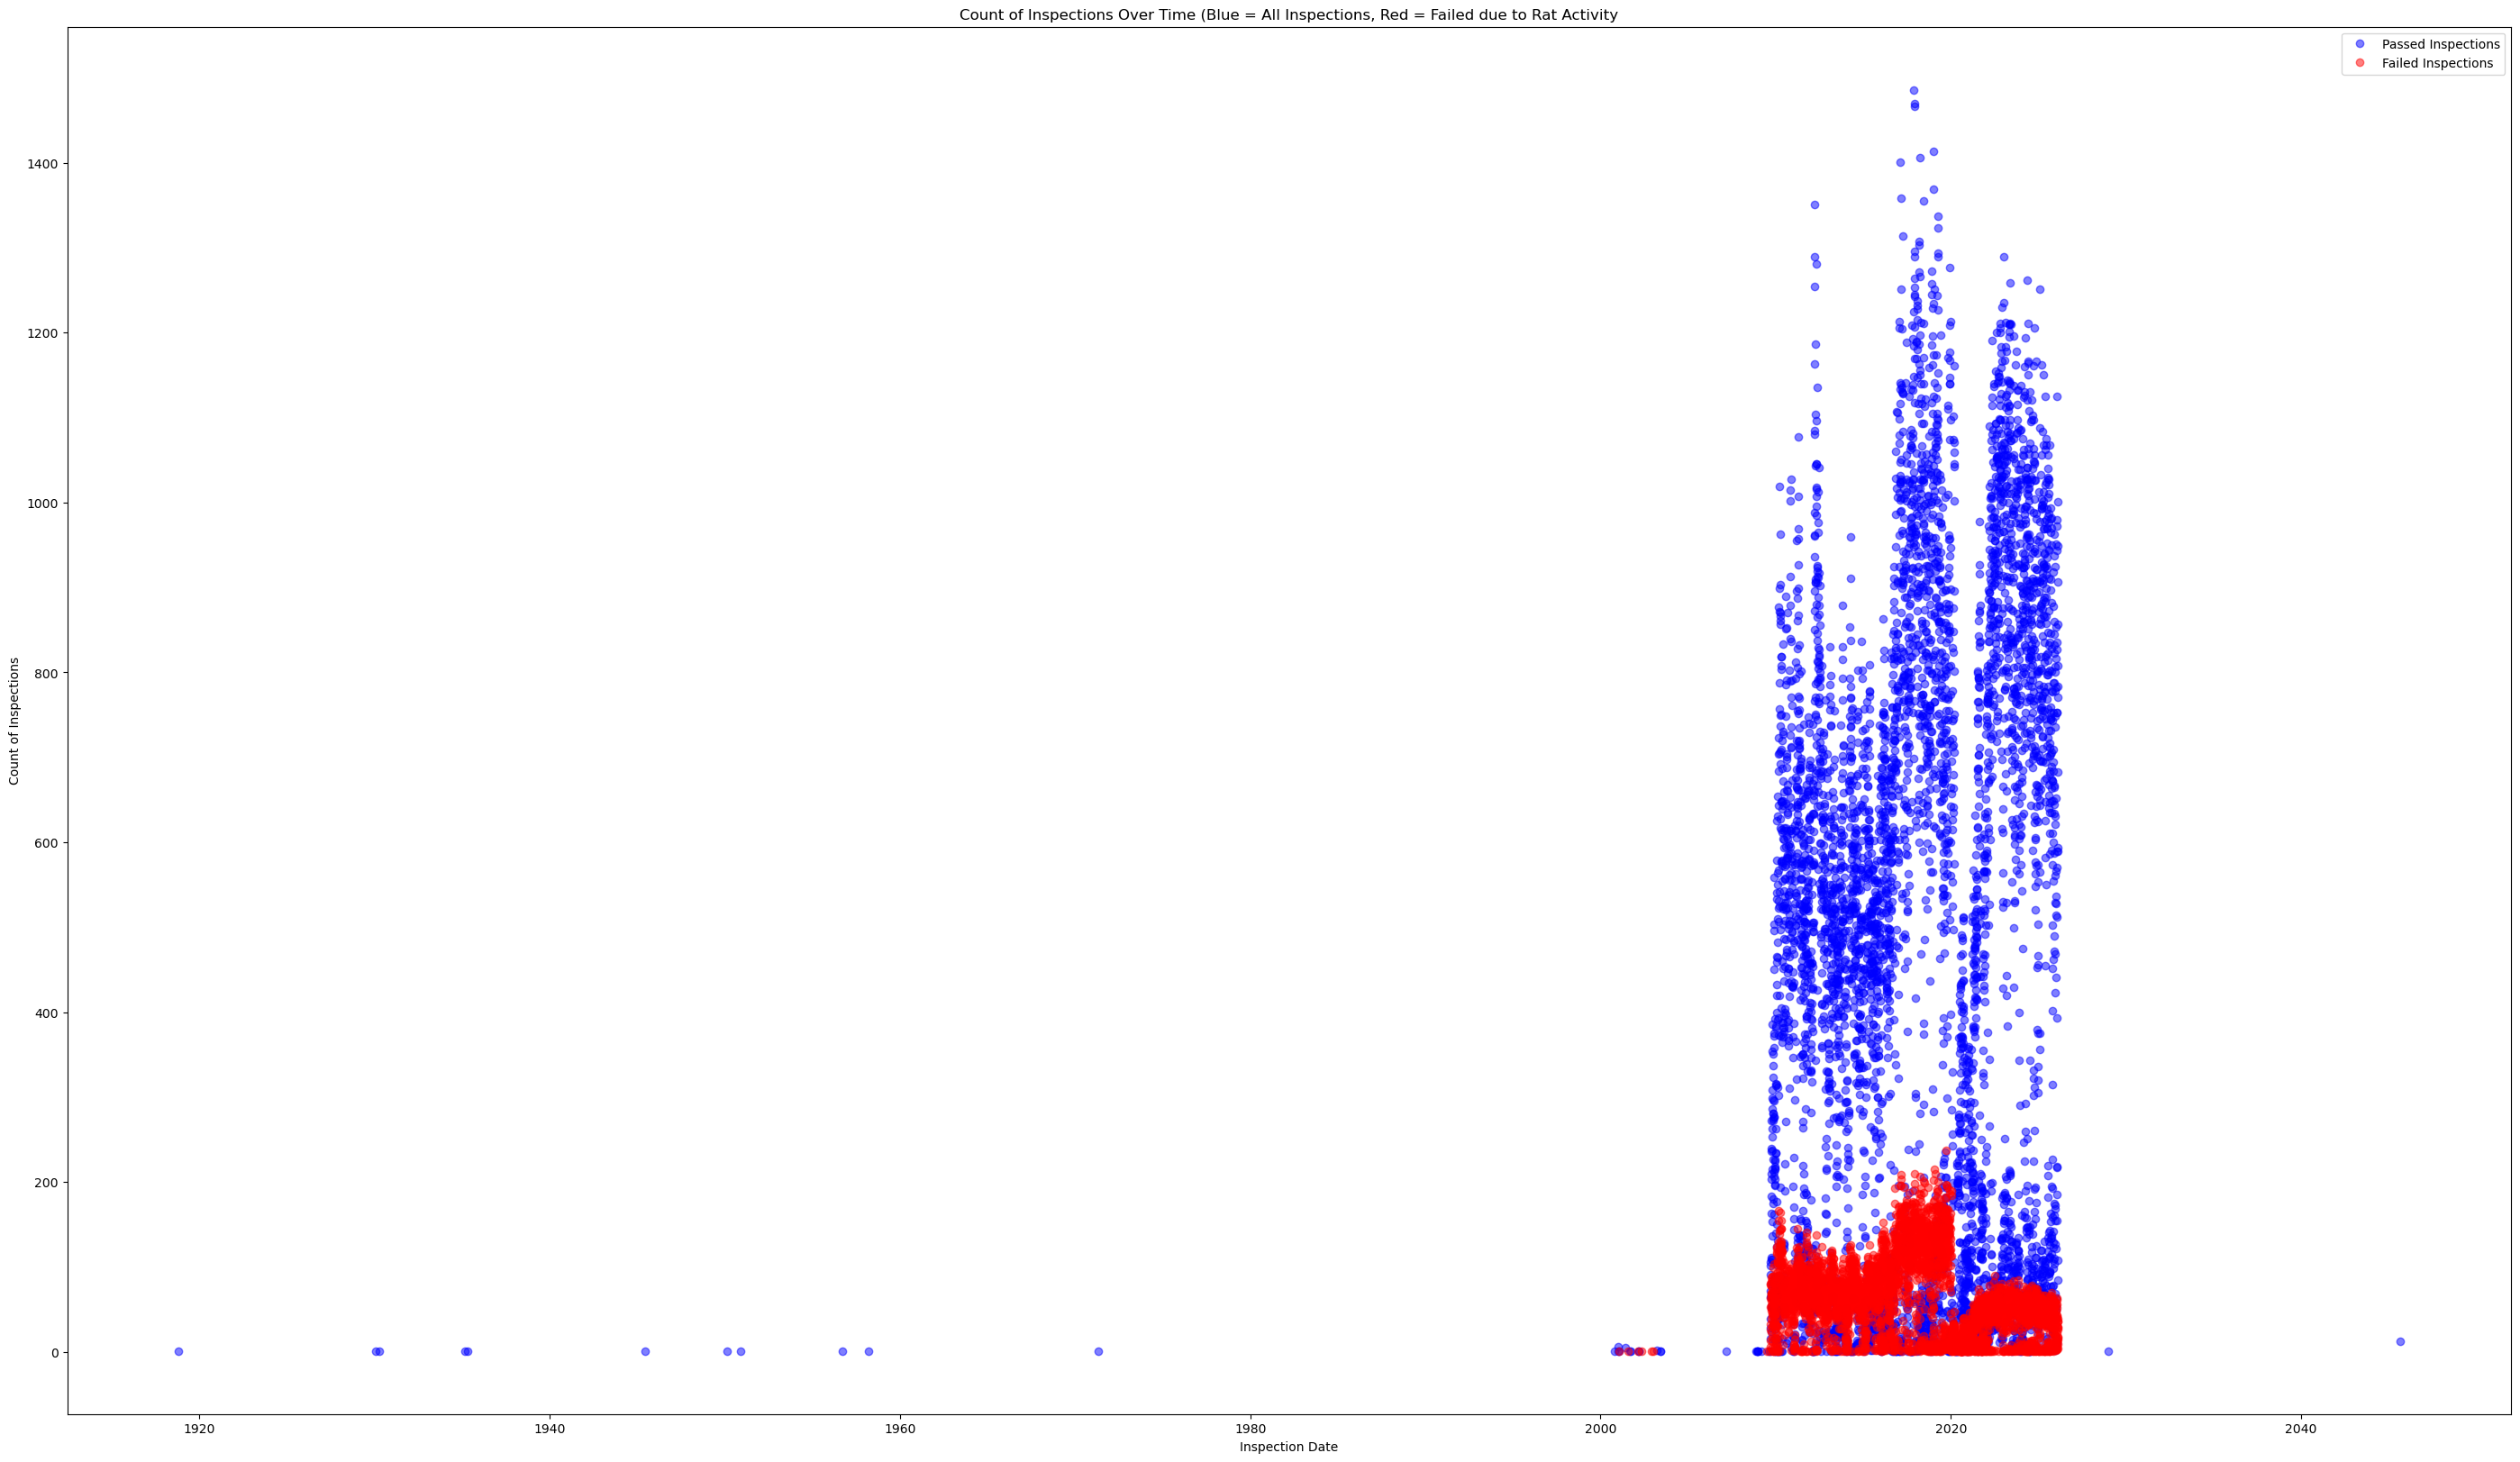

In [11]:
failed_rat_act = rat_insp[rat_insp['result'] == 'Failed for Rat Act']
failedidate = failed_rat_act.groupby(failed_rat_act['inspection_date'].dt.date).size().reset_index(name='count')
notfail = rat_insp[rat_insp['result'] != 'Failed for Rat Act']
idate = notfail.groupby(notfail['inspection_date'].dt.date).size().reset_index(name='count')


plt.figure(figsize=(35,20))
plt.plot(idate['inspection_date'], idate['count'], 'o', color="b", alpha=0.50, label='Passed Inspections')
plt.plot(failedidate['inspection_date'], failedidate['count'], 'o', color="r", alpha=0.50, label='Failed Inspections')
plt.xlabel('Inspection Date')
plt.ylabel('Count of Inspections')
plt.legend()
plt.title('Count of Inspections Over Time (Blue = All Inspections, Red = Failed due to Rat Activity')
plt.show()

In [12]:
# Most of the data appears concentrated between 2010 to present day.

rat_insp['inspection_date'].describe()

count                       2995909
mean     2018-07-23 06:41:00.307790
min             1918-10-19 14:34:44
25%             2014-10-01 09:35:45
50%             2018-07-25 08:20:22
75%             2022-11-15 15:01:28
max             2045-08-28 12:22:07
Name: inspection_date, dtype: object

In [13]:
# we keep entries between 01-01-2010 and present day.

today = pd.to_datetime("today").strftime("%m/%d/%Y")

rat_insp = rat_insp[(rat_insp['inspection_date'] >= '2010-01-01') & (rat_insp['inspection_date'] <= today)]

In [14]:
import plotly.figure_factory as ff


# Add a dummy column to count each row
rat_insp['dummy_count'] = 1

fig = ff.create_hexbin_mapbox(
    data_frame=rat_insp,
    lat="latitude",
    lon="longitude",
    nx_hexagon=20,             # Number of hexagons in x direction
    color="dummy_count",       # Sum of dummy_count = number of occurrences
    agg_func=np.sum,           # Sum the dummy column
    opacity=0.85,
    labels={"color": "Number of Inspections"},
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(b=0, t=0, l=0, r=0),
)
fig.show()

rat_insp.drop(columns=['dummy_count'], inplace=True)


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:122: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(x).astype(int)
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:123: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(y).astype(int)
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:124: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(x).astype(int)
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:125: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(y).astype(int)


In [15]:
# The above map has points not in New York City.
display(rat_insp[['latitude', 'longitude']].describe())

,latitude,longitude
count,2.954069e+06,2.954069e+06
mean,4.050321e+01,-7.346803e+01
std,3.225157e+00,5.848038e+00
min,-1.890702e+01,-7.946610e+01
25%,4.069399e+01,-7.395832e+01
50%,4.075493e+01,-7.393543e+01
75%,4.082990e+01,-7.390294e+01
max,4.091286e+01,0.000000e+00


In [16]:
# Let's look at the rows with the minimum and maximum latitude and longitude values to see if there are any obvious errors or outliers.
display(rat_insp[rat_insp['latitude'] == rat_insp['latitude'].min()])
display(rat_insp[rat_insp['latitude'] == rat_insp['latitude'].max()])
display(rat_insp[rat_insp['longitude'] == rat_insp['longitude'].min()])
display(rat_insp[rat_insp['longitude'] == rat_insp['longitude'].max()])

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
536832,Initial,11496541,PC7335420,1,NaN,11518.0,26.0,pitkin,CENTREVILLE STREET,11417.0,...,-79.466103,Queens,2010-01-14 08:36:00,Failed for Other R,01/20/2010 10:58:28 AM,NaN,NaN,NaN,NaN,NaN
1262150,Compliance,12743670,PC7335420,2,NaN,11518.0,26.0,pitkin,CENTREVILLE STREET,11417.0,...,-79.466103,Queens,2010-03-04 13:10:29,Failed for Other R,03/11/2010 09:34:29 AM,NaN,NaN,NaN,NaN,NaN


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
93182,Initial,13137556,PC7566163,1,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2020-02-19 16:15:00,Failed for Other R,02/20/2020 11:18:11 AM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
222405,Initial,11276206,PC6574764,1,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2013-06-26 16:15:09,Passed,07/01/2013 10:27:51 AM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
1053954,Initial,13317869,PC7790008,1,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2022-01-21 15:10:00,Rat Activity,01/24/2022 11:55:33 AM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
2258197,Compliance,12908823,PC6747165,2,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2015-08-11 16:10:08,Passed,08/12/2015 03:43:37 PM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
2383498,Initial,11316535,PC6747165,1,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2014-11-21 16:00:51,Failed for Rat Act,11/24/2014 09:21:05 AM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
2582424,Initial,11432848,PC6830727,1,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2018-06-28 15:55:37,Passed,06/29/2018 10:24:47 AM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil
2638074,Compliance,13335480,PC7790008,2,2.058912e+09,5891.0,1601.0,6300,RIVERDALE AVENUE,10471.0,...,-73.902472,Bronx,2022-02-24 16:25:00,Rat Activity,03/01/2022 12:17:06 PM,8.0,11.0,337.0,2085753.0,Riverdale-Spuyten Duyvil


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
536832,Initial,11496541,PC7335420,1,NaN,11518.0,26.0,pitkin,CENTREVILLE STREET,11417.0,...,-79.466103,Queens,2010-01-14 08:36:00,Failed for Other R,01/20/2010 10:58:28 AM,NaN,NaN,NaN,NaN,NaN
1262150,Compliance,12743670,PC7335420,2,NaN,11518.0,26.0,pitkin,CENTREVILLE STREET,11417.0,...,-79.466103,Queens,2010-03-04 13:10:29,Failed for Other R,03/11/2010 09:34:29 AM,NaN,NaN,NaN,NaN,NaN


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
156,Initial,12433507,PC6860206,1,2.032440e+09,3244.0,130.0,2371,EXTERIOR STREET,NaN,...,0.0,Bronx,2018-04-23 13:55:45,Passed,04/26/2018 08:15:44 AM,7.0,14.0,269.0,2118773.0,University Heights (North)-Fordham
384,Initial,11509316,PC7493624,1,NaN,1262.0,19.0,00000,SOUTH AVENUE,NaN,...,0.0,Staten Island,2010-11-05 11:55:17,Failed for Other R,11/08/2010 12:47:37 PM,NaN,NaN,NaN,NaN,NaN
552,Initial,12649499,PC6862937,1,NaN,5520.0,33.0,3081,PRENTISS AVENUE,NaN,...,0.0,Bronx,2019-08-20 11:12:45,Passed,08/23/2019 02:09:21 PM,NaN,NaN,NaN,NaN,NaN
575,Compliance,12790923,PC7501076,2,NaN,3349.0,2.0,00,HURLBERT STREET,NaN,...,0.0,Staten Island,2011-07-20 15:55:36,Passed,07/21/2011 10:32:44 AM,NaN,NaN,NaN,NaN,NaN
600,Compliance,12800894,PC7500218,2,NaN,505.0,25.0,00,CLINTON STREET,NaN,...,0.0,Staten Island,2011-11-01 14:50:36,Passed,11/03/2011 10:44:48 AM,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995247,Initial,13694097,PC8167079,1,NaN,315.0,76.0,000,GRAND STREET,NaN,...,0.0,Manhattan,2023-08-04 08:56:00,Passed,08/07/2023 08:27:34 AM,NaN,NaN,NaN,NaN,NaN
2995430,Initial,12195501,PC6348508,1,NaN,1926.0,1.0,2230,********************,NaN,...,0.0,Manhattan,2016-09-27 14:35:09,Passed,10/05/2016 08:08:49 AM,NaN,NaN,NaN,NaN,NaN
2995439,Initial,11335643,PC6268819,1,1.019280e+09,1928.0,36.0,2060,ADAM CLAYTON POWELL BOULEVARD,NaN,...,0.0,Manhattan,2015-07-24 13:40:30,Passed,07/27/2015 09:07:48 AM,10.0,9.0,222.0,1058567.0,Harlem (South)
2995855,Initial,14032845,PC8494181,1,NaN,2504.0,1.0,000,JEROME AVENUE,NaN,...,0.0,Bronx,2025-02-20 08:00:00,Failed for Rat Act,02/21/2025 09:26:27 AM,NaN,NaN,NaN,NaN,NaN


In [17]:
# For these entries, let's set their latitude and longitude values to NaN since they are likely to be errors.
rat_insp.loc[rat_insp['latitude'] == rat_insp['latitude'].min(), ['latitude', 'longitude']] = np.nan
rat_insp.loc[rat_insp['latitude'] == rat_insp['latitude'].max(), ['latitude', 'longitude']] = np.nan
rat_insp.loc[rat_insp['longitude'] == rat_insp['longitude'].min(), ['latitude', 'longitude']] = np.nan
rat_insp.loc[rat_insp['longitude'] == rat_insp['longitude'].max(), ['latitude', 'longitude']] = np.nan

In [18]:
pip install geopy pandas

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Let's make sure that we deal with entries with weird 'zip_code' entries.
# The weird zip-codes are 0, 458, 1045, 12345.



In [20]:
zipcodes = rat_insp['zip_code'].values
zipcodes = np.unique(zipcodes)
display(zipcodes)


array([    0.,   458.,  1045., 10000., 10001., 10002., 10003., 10004.,
       10005., 10006., 10007., 10009., 10010., 10011., 10012., 10013.,
       10014., 10016., 10017., 10018., 10019., 10020., 10021., 10022.,
       10023., 10024., 10025., 10026., 10027., 10028., 10029., 10030.,
       10031., 10032., 10033., 10034., 10035., 10036., 10037., 10038.,
       10039., 10040., 10041., 10044., 10045., 10055., 10065., 10069.,
       10075., 10103., 10105., 10106., 10110., 10112., 10115., 10118.,
       10119., 10120., 10121., 10122., 10123., 10128., 10151., 10152.,
       10153., 10154., 10155., 10158., 10162., 10165., 10167., 10168.,
       10169., 10170., 10171., 10172., 10173., 10174., 10176., 10177.,
       10178., 10271., 10278., 10279., 10280., 10281., 10282., 10301.,
       10302., 10303., 10304., 10305., 10306., 10307., 10308., 10309.,
       10310., 10312., 10314., 10451., 10452., 10453., 10454., 10455.,
       10456., 10457., 10458., 10459., 10460., 10461., 10462., 10463.,
      

In [21]:
display(rat_insp[rat_insp['zip_code'].isna()])

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
156,Initial,12433507,PC6860206,1,2.032440e+09,3244.0,130.0,2371,EXTERIOR STREET,NaN,...,NaN,Bronx,2018-04-23 13:55:45,Passed,04/26/2018 08:15:44 AM,7.0,14.0,269.0,2118773.0,University Heights (North)-Fordham
384,Initial,11509316,PC7493624,1,NaN,1262.0,19.0,00000,SOUTH AVENUE,NaN,...,NaN,Staten Island,2010-11-05 11:55:17,Failed for Other R,11/08/2010 12:47:37 PM,NaN,NaN,NaN,NaN,NaN
552,Initial,12649499,PC6862937,1,NaN,5520.0,33.0,3081,PRENTISS AVENUE,NaN,...,NaN,Bronx,2019-08-20 11:12:45,Passed,08/23/2019 02:09:21 PM,NaN,NaN,NaN,NaN,NaN
575,Compliance,12790923,PC7501076,2,NaN,3349.0,2.0,00,HURLBERT STREET,NaN,...,NaN,Staten Island,2011-07-20 15:55:36,Passed,07/21/2011 10:32:44 AM,NaN,NaN,NaN,NaN,NaN
600,Compliance,12800894,PC7500218,2,NaN,505.0,25.0,00,CLINTON STREET,NaN,...,NaN,Staten Island,2011-11-01 14:50:36,Passed,11/03/2011 10:44:48 AM,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995247,Initial,13694097,PC8167079,1,NaN,315.0,76.0,000,GRAND STREET,NaN,...,NaN,Manhattan,2023-08-04 08:56:00,Passed,08/07/2023 08:27:34 AM,NaN,NaN,NaN,NaN,NaN
2995430,Initial,12195501,PC6348508,1,NaN,1926.0,1.0,2230,********************,NaN,...,NaN,Manhattan,2016-09-27 14:35:09,Passed,10/05/2016 08:08:49 AM,NaN,NaN,NaN,NaN,NaN
2995439,Initial,11335643,PC6268819,1,1.019280e+09,1928.0,36.0,2060,ADAM CLAYTON POWELL BOULEVARD,NaN,...,NaN,Manhattan,2015-07-24 13:40:30,Passed,07/27/2015 09:07:48 AM,10.0,9.0,222.0,1058567.0,Harlem (South)
2995855,Initial,14032845,PC8494181,1,NaN,2504.0,1.0,000,JEROME AVENUE,NaN,...,NaN,Bronx,2025-02-20 08:00:00,Failed for Rat Act,02/21/2025 09:26:27 AM,NaN,NaN,NaN,NaN,NaN


In [22]:
display(rat_insp[rat_insp['zip_code']== 0])

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
175,Initial,12102314,PC6755394,1,NaN,3237.0,52.0,NaN,HEATH AVENUE,0.0,...,-73.907337,Bronx,2015-10-02 15:01:00,Passed,10/13/2015 11:39:55 AM,NaN,NaN,NaN,NaN,NaN
1031,Initial,12054139,PC6688276,1,NaN,3110.0,33.0,NaN,EAST 180 STREET,0.0,...,-73.885899,Bronx,2015-03-17 12:05:43,Passed,03/26/2015 08:54:10 AM,NaN,NaN,NaN,NaN,NaN
2652,Initial,12363533,PC7133260,1,NaN,1412.0,101.0,NaN,NaN,0.0,...,-73.939408,Brooklyn,2017-11-28 11:44:15,Passed,11/30/2017 05:08:39 PM,NaN,NaN,NaN,NaN,NaN
2725,Initial,12464880,PC6417937,1,NaN,1077.0,9.0,NaN,WEST 48 STREET,0.0,...,-73.994573,Manhattan,2018-06-20 15:56:03,Passed,06/28/2018 02:44:59 PM,NaN,NaN,NaN,NaN,NaN
3759,Initial,12156933,PC6227448,1,NaN,1957.0,3.0,NaN,ST NICHOLAS AVENUE,0.0,...,-73.950945,Manhattan,2016-05-02 09:20:30,Passed,05/03/2016 10:37:16 AM,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993231,Initial,12244577,PC6222110,1,NaN,1171.0,9.0,NaN,MILLER HIGHWAY,0.0,...,-73.988955,Manhattan,2017-02-13 11:31:42,Passed,02/21/2017 10:37:32 AM,NaN,NaN,NaN,NaN,NaN
2994411,Initial,11569688,PC7481608,1,NaN,3864.0,4.0,NaN,OCEANSIDE AVENUE,0.0,...,-74.086471,Staten Island,2016-08-23 12:39:01,Failed for Other R,08/25/2016 08:59:09 AM,NaN,NaN,NaN,NaN,NaN
2995557,Initial,12572028,PC6883621,1,NaN,3078.0,8902.0,NaN,NaN,0.0,...,-73.885066,Bronx,2019-03-08 13:17:46,Passed,03/11/2019 12:54:48 PM,NaN,NaN,NaN,NaN,NaN
2995792,Initial,12548565,PC6917119,1,NaN,2506.0,126.0,NaN,NaN,0.0,...,-73.921969,Bronx,2019-01-14 15:12:42,Passed,01/16/2019 10:08:48 AM,NaN,NaN,NaN,NaN,NaN


In [23]:
display(rat_insp[rat_insp['zip_code']== 458])
display(rat_insp[rat_insp['zip_code']== 1045])

# We drop the entries with 'zip_code' 458 or 1045 for lack of information.
rat_insp = rat_insp[(rat_insp['zip_code'] != 458) & (rat_insp['zip_code'] != 1045)]

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
648197,Initial,13154137,PC7592458,1,NaN,3031.0,75.0,NaN,NaN,458.0,...,NaN,Bronx,2020-03-13 14:20:24,Failed for Rat Act,03/23/2020 02:32:13 PM,NaN,NaN,NaN,NaN,NaN


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
2562946,Initial,13236234,PC7712187,1,NaN,2459.0,50.0,NaN,NaN,1045.0,...,NaN,Bronx,2021-05-28 09:11:00,Passed,06/04/2021 11:59:32 AM,NaN,NaN,NaN,NaN,NaN


In [24]:
display(rat_insp[rat_insp['zip_code']== 12345])

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
5788,Initial,11935396,PC6138984,1,NaN,2024.0,134.0,2374,ADAM C POWELL BLVD,12345.0,...,-73.941974,Manhattan,2013-09-05 14:00:15,Passed,09/10/2013 12:42:50 PM,NaN,NaN,NaN,NaN,NaN
13459,Initial,11841274,PC6130764,1,NaN,2024.0,33.0,2370,ADAM C POWELL BLVD,12345.0,...,-73.942075,Manhattan,2012-06-12 12:26:09,Passed,06/14/2012 12:03:51 PM,NaN,NaN,NaN,NaN,NaN
26381,Initial,11935395,PC6148396,1,NaN,2024.0,34.0,2372,ADAM C POWELL BLVD,12345.0,...,-73.942006,Manhattan,2013-09-05 13:55:41,Passed,09/10/2013 12:42:50 PM,NaN,NaN,NaN,NaN,NaN
30551,Compliance,13345289,PC7791156,2,NaN,2024.0,34.0,2372,ADAM C POWELL BLVD,12345.0,...,-73.942006,Manhattan,2022-03-11 11:20:50,Rat Activity,03/14/2022 01:15:30 PM,NaN,NaN,NaN,NaN,NaN
37060,Initial,12427458,PC6389163,1,NaN,2024.0,35.0,2376,ADAM C POWELL BLVD,12345.0,...,-73.941941,Manhattan,2018-04-11 13:50:05,Passed,04/17/2018 08:19:17 AM,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949741,Initial,12194575,PC6203525,1,NaN,2024.0,134.0,2374,ADAM C POWELL BLVD,12345.0,...,-73.941974,Manhattan,2016-09-28 10:30:16,Passed,09/29/2016 03:26:24 PM,NaN,NaN,NaN,NaN,NaN
2960606,Initial,12043383,PC6329066,1,NaN,2024.0,34.0,2372,ADAM C POWELL BLVD,12345.0,...,-73.942006,Manhattan,2015-01-16 12:12:30,Passed,01/23/2015 01:39:20 PM,NaN,NaN,NaN,NaN,NaN
2971230,Initial,11841275,PC6130629,1,NaN,2024.0,34.0,2372,ADAM C POWELL BLVD,12345.0,...,-73.942006,Manhattan,2012-06-12 12:31:36,Passed,06/14/2012 12:03:51 PM,NaN,NaN,NaN,NaN,NaN
2971345,Initial,12427572,PC6409628,1,NaN,2024.0,34.0,2372,ADAM C POWELL BLVD,12345.0,...,-73.942006,Manhattan,2018-04-11 13:42:02,Passed,04/17/2018 08:19:10 AM,NaN,NaN,NaN,NaN,NaN


In [25]:
null_coords = rat_insp[rat_insp['latitude'].isna() | rat_insp['longitude'].isna()]
display(null_coords)

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
2,Initial,13843130,PC8298604,1,NaN,393.0,59.0,EAST,10 STREET,10009.0,...,NaN,Manhattan,2024-04-17 10:56:00,Passed,04/18/2024 10:31:45 AM,NaN,NaN,NaN,NaN,NaN
135,Initial,13473093,PC7939803,1,NaN,2839.0,49.0,CLARKE,PLACE,10452.0,...,NaN,Bronx,2022-09-12 12:22:00,Passed,09/19/2022 09:08:16 AM,NaN,NaN,NaN,NaN,NaN
156,Initial,12433507,PC6860206,1,2.032440e+09,3244.0,130.0,2371,EXTERIOR STREET,NaN,...,NaN,Bronx,2018-04-23 13:55:45,Passed,04/26/2018 08:15:44 AM,7.0,14.0,269.0,2118773.0,University Heights (North)-Fordham
302,Initial,13679413,PC8148667,1,NaN,33325.0,50.0,NaN,NaN,10467.0,...,NaN,Bronx,2023-07-11 11:30:32,Rat Activity,07/14/2023 10:16:04 AM,NaN,NaN,NaN,NaN,NaN
384,Initial,11509316,PC7493624,1,NaN,1262.0,19.0,00000,SOUTH AVENUE,NaN,...,NaN,Staten Island,2010-11-05 11:55:17,Failed for Other R,11/08/2010 12:47:37 PM,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995430,Initial,12195501,PC6348508,1,NaN,1926.0,1.0,2230,********************,NaN,...,NaN,Manhattan,2016-09-27 14:35:09,Passed,10/05/2016 08:08:49 AM,NaN,NaN,NaN,NaN,NaN
2995439,Initial,11335643,PC6268819,1,1.019280e+09,1928.0,36.0,2060,ADAM CLAYTON POWELL BOULEVARD,NaN,...,NaN,Manhattan,2015-07-24 13:40:30,Passed,07/27/2015 09:07:48 AM,10.0,9.0,222.0,1058567.0,Harlem (South)
2995643,Initial,13398335,PC7871193,1,NaN,4558.0,34.0,ADEE,AVENUE,10469.0,...,NaN,Bronx,2022-05-26 16:18:30,Failed for Other R,05/27/2022 08:47:05 AM,NaN,NaN,NaN,NaN,NaN
2995855,Initial,14032845,PC8494181,1,NaN,2504.0,1.0,000,JEROME AVENUE,NaN,...,NaN,Bronx,2025-02-20 08:00:00,Failed for Rat Act,02/21/2025 09:26:27 AM,NaN,NaN,NaN,NaN,NaN


In [26]:
from scipy.spatial import cKDTree

# load the zip_code data
zip_db = pd.read_csv("map_data_for_cleaning/uszips.csv")
zip_db = zip_db[['zip', 'lat', 'lng']].dropna()

# Remove invalid (NaN or inf) coordinates
zip_db = zip_db[np.isfinite(zip_db['lat']) & np.isfinite(zip_db['lng'])]

# Build KDTree
tree = cKDTree(zip_db[['lat', 'lng']].values)

def nearest_zip(lat, lon):
    """Return ZIP code nearest to a given latitude/longitude."""
    if not np.isfinite(lat) or not np.isfinite(lon):
        return pd.NA  # skip invalid coordinates
    distance, idx = tree.query([lat, lon])
    return int(zip_db.iloc[idx]['zip'])

# fix problematic rows
zip_codes_to_fix = {0, 12345}
mask = rat_insp["zip_code"].isin(zip_codes_to_fix)

# Only apply to rows with valid lat/lon
valid_mask = mask & rat_insp['latitude'].notna() & rat_insp['longitude'].notna()

rat_insp.loc[valid_mask, 'zip_code'] = rat_insp.loc[valid_mask].apply(
    lambda r: nearest_zip(r['latitude'], r['longitude']),
    axis=1
)

In [27]:
# Let's save the cleaned dataframe to a new csv file for future use.
# Since the dataframe is quite large, we will split it up into multiple csv files 
# based on the year of the inspection date.
for year in rat_insp['inspection_date'].dt.year.unique():
    yearly_data = rat_insp[rat_insp['inspection_date'].dt.year == year]
    yearly_data.to_csv(f'../data/cleaned_rat_inspection_data/cleaned_rat_inspection_{year}.csv', index=False)

<Axes: >

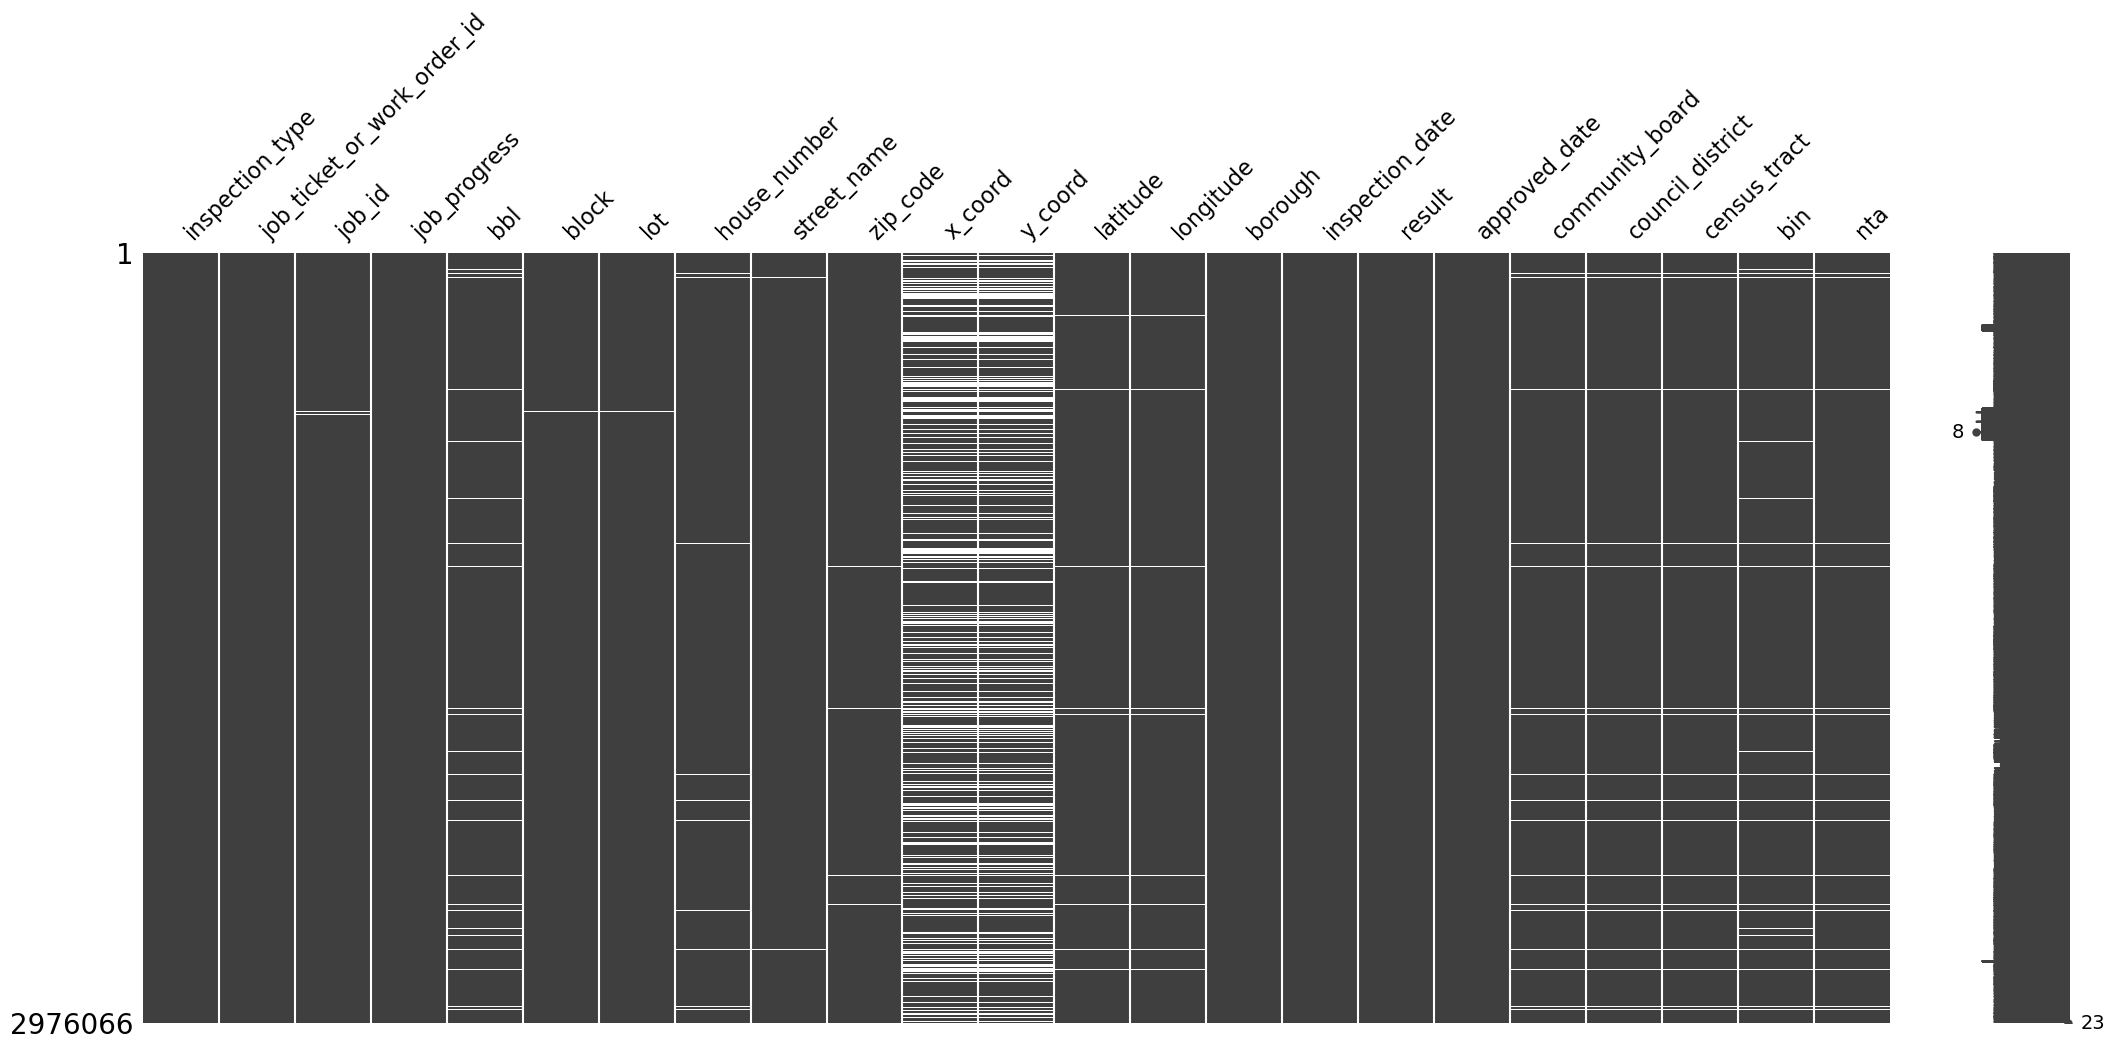

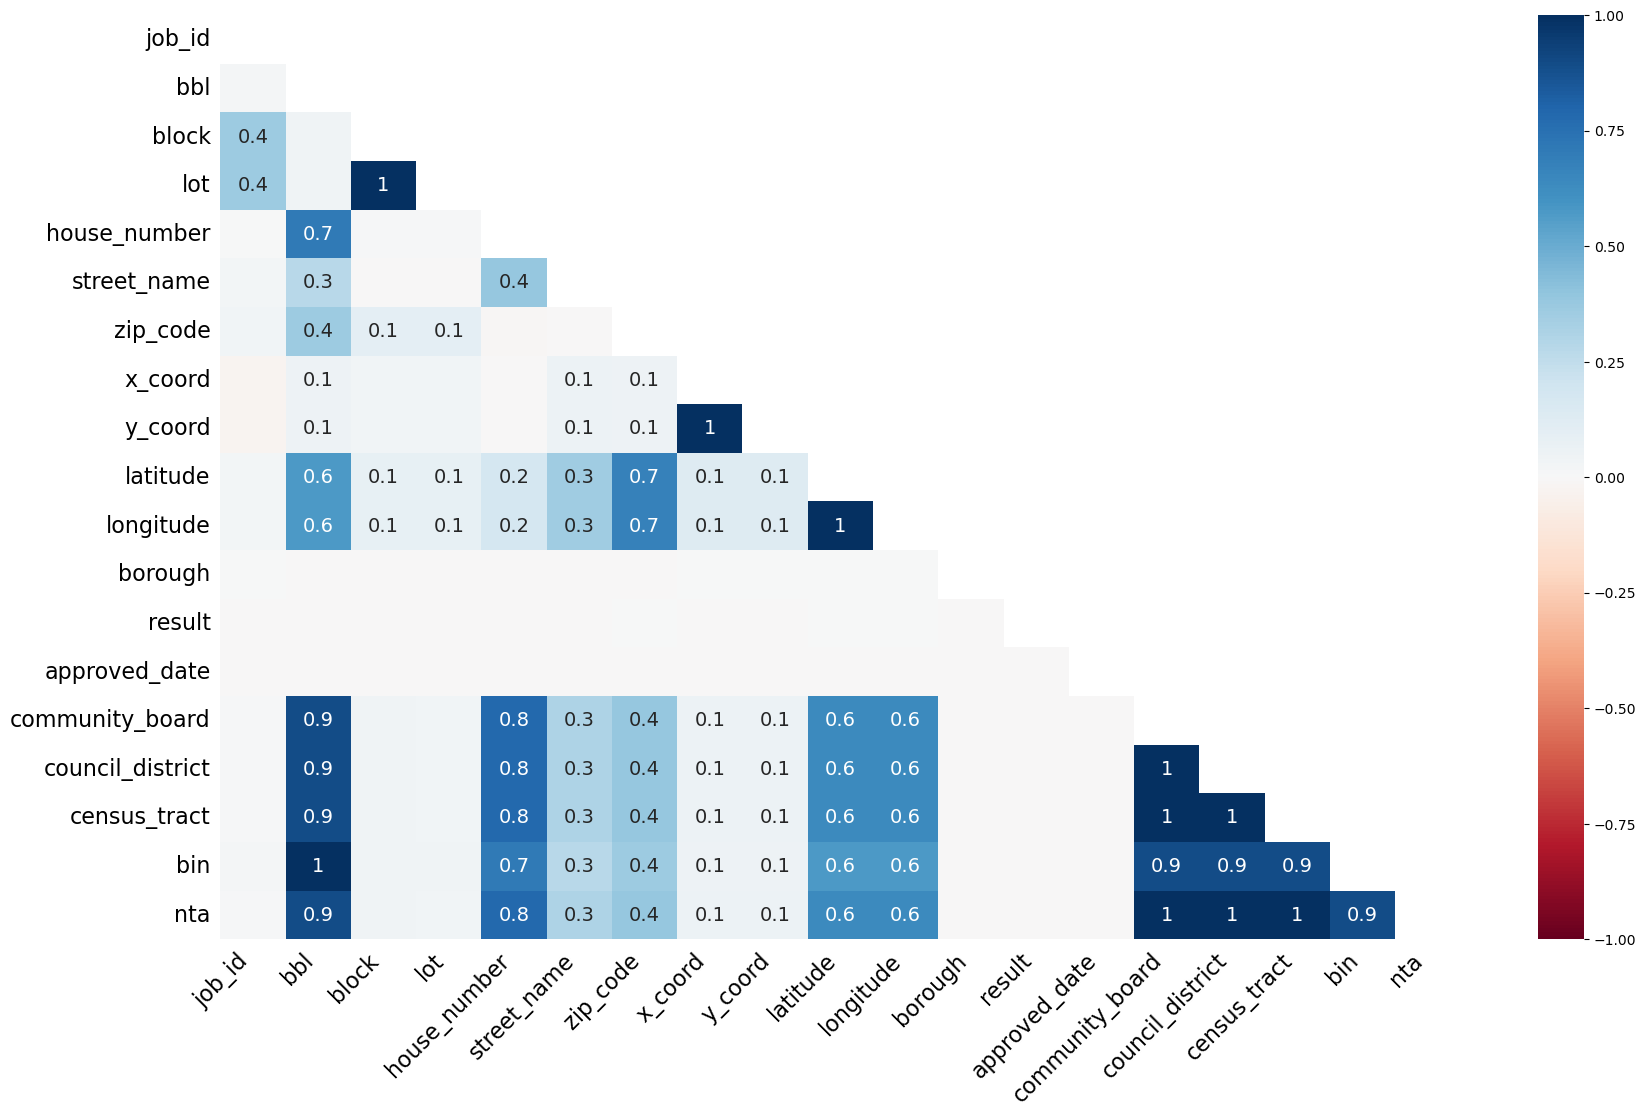

In [28]:
msno.matrix(rat_insp)
msno.heatmap(rat_insp)